Iantsa Provost et Bastien Soucasse – Groupe 5

# Projet d'ACID – 2 janvier 2022

## Introduction

Afin de se lancer dans la comparaison des différents algorithmes de _Machine Learning_, il nous faut des données à exploiter pour l'entraînement et en guise de test.

Commençons par importer les modules et classes nécessaires au bon fonctionnement du projet.

In [5]:
from tensorflow.keras.datasets import fashion_mnist

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np

import time

%matplotlib inline

VERBOSE = True

On peut alors récupérer les données à traiter à l'aide de **keras**.

In [7]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0

assert len(X_train.shape) == 3
assert len(X_test.shape) == 3
assert len(y_train.shape) == 1
assert len(y_test.shape) == 1

if (VERBOSE):
    print('X_train.shape =', X_train.shape)
    print('y_train.shape =', y_train.shape)
    print('X_test.shape =', X_test.shape)
    print('y_test.shape =', y_test.shape)

X_train.shape = (60000, 28, 28)
y_train.shape = (60000,)
X_test.shape = (10000, 28, 28)
y_test.shape = (10000,)


Si besoin, on peut avoir un aperçu des données.

X_train[0]:


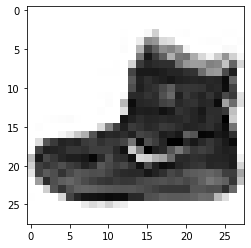

y_train[0] = 9
X_train[1]:


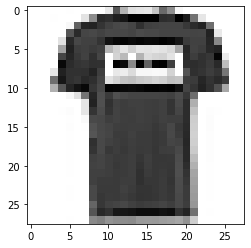

y_train[1] = 0
X_train[2]:


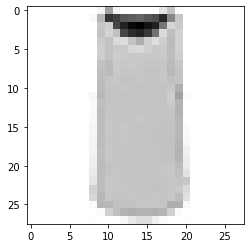

y_train[2] = 0
X_train[3]:


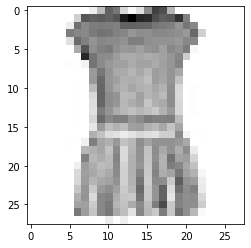

y_train[3] = 3
X_train[4]:


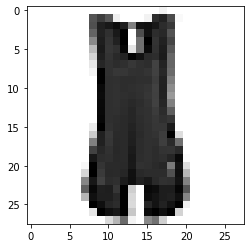

y_train[4] = 0


In [3]:
if VERBOSE:
    NUM_EXAMPLES = 5

    for i in range(NUM_EXAMPLES):
        print('X_train[%d]:' % i)
        plt.imshow(X_train[i], cmap = cm.Greys)
        plt.show()
        print('y_train[%d] =' % i, y_train[i])

On a également besoin d'applatir les données.

In [8]:
X_train, X_test = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2]), X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

assert len(X_train.shape) == 2
assert len(X_test.shape) == 2

if (VERBOSE):
    print('X_train.shape =', X_train.shape)
    print('X_test.shape =', X_test.shape)

X_train.shape = (60000, 784)
X_test.shape = (10000, 784)


## Réductions de dimension

Afin de comparer un large panel de classifications, on va mettre en place deux réductions de dimensions qui seront appliquées une à une à chaque modèle de classification. Cela permettra de tenter d'améliorer nos accuracy tout en gagnant du temps de calcul.

- Analyse en composantes principales
- Analyse linéaire discriminante

### Analyse en composantes principales

On commence par centrer les données.

In [5]:
scaler = StandardScaler()
X = np.concatenate((X_train, X_test))
z = scaler.fit_transform(X)

On peut maintenant commencer l'ACP.

In [6]:
pca = PCA()
coord = pca.fit_transform(z)

if VERBOSE:
    print('n_components =', pca.n_components_)

n_components = 784


Fions-nous au critère du coude pour définir le nombre d'axes que l'on va retenir. Pour ce faire, nous allons construire l'éboulis des valeurs propres grâce à une fonction.

In [7]:
def display_scree_plot(n_components, explained_variance_ratio):
    plt.grid()
    plt.plot(np.arange(1, n_components+1), explained_variance_ratio)
    plt.title('Scree Plot')
    plt.ylabel('Eigen Values')
    plt.xlabel('Factor Number')
    plt.show()

On peut ainsi afficher notre éboulis et tenter de trouver le décrochement.

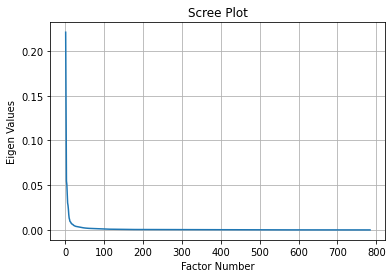

In [8]:
display_scree_plot(pca.n_components_, pca.explained_variance_ratio_)

En l'état, l'éboulis n'est pas vraiment lisible. Cependant, on remarque qu'à partir d'un certain facteur, la valeur propre est plutôt constante. On peut donc tronquer cette partie, ce qui nous permettra de « zoomer » sur le décrochement que l'on cherche.

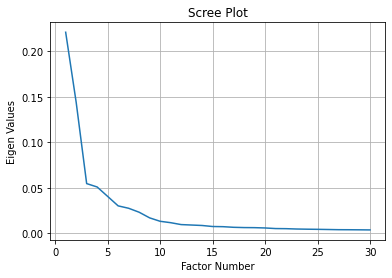

In [9]:
display_scree_plot(30, pca.explained_variance_ratio_[:30])

Nous ne sommes pas sûrs si le « décrochement » se fait plutôt pour la valeur 3 ou 6. Observons alors la variance totale pour ces valeurs. On va utiliser une fonction pour simplifier ce processus.

In [10]:
def display_total_variance(p):
    pca = PCA(n_components=p)
    pca.fit_transform(z)
    print('Total variance for p = %d: %.2f%%' % (p, pca.explained_variance_ratio_.sum() * 100))

On peut alors comparer nos deux valeurs.

In [11]:
display_total_variance(3)
display_total_variance(6)

Total variance for p = 3: 41.96%
Total variance for p = 6: 54.12%


Choisissons 6 car elle permet de garder au moins 50% de la variance.

Notons tout de même que dans les 2 cas, le pourcentage de variance conservée est plutôt bas. Également, 6 est un nombre d'axes plutôt élevé. On peut en déduire que l'ACP n'est sûrement pas la meilleure réduction de dimension.

In [12]:
ACP_N_COMPONENTS = 6

Et voilà, notre ACP finale peut alors voir le jour.

In [13]:
pca = PCA(n_components=ACP_N_COMPONENTS)

X = np.concatenate((X_train, X_test))
z = scaler.fit_transform(X)
Xp = pca.fit_transform(z)
Xp_train = Xp[:X_train.shape[0]]
Xp_test = Xp[X_train.shape[0]:]

if VERBOSE:
    print('Xp_train.shape =', Xp_train.shape)
    print('Xp_test.shape =', Xp_test.shape)

Xp_train.shape = (60000, 6)
Xp_test.shape = (10000, 6)


### Analyse linéaire discriminante

En se basant sur le travail effectué pour réaliser l'ACP, on peut mettre en place l'ALD.

In [14]:
lda = LDA()

X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

X_lda = lda.fit_transform(X, y)
Xl_train = X_lda[:X_train.shape[0]]
Xl_test = X_lda[X_train.shape[0]:]

if VERBOSE:
    print('Xl_train.shape =', Xl_train.shape)
    print('Xl_test.shape =', Xl_test.shape)

Xl_train.shape = (60000, 9)
Xl_test.shape = (10000, 9)


Ratio de la variance expliquée par les axes obtenus :

In [15]:
lda.explained_variance_ratio_

array([0.44775652, 0.21875177, 0.09237004, 0.07396008, 0.06062643,
       0.04305586, 0.03801965, 0.01584194, 0.00961772])

On peut en déduire qu'on garde 9 axes.

## Classifications des données

Cette partie est dédiée concrètement au _Machine Learning_. Pour classifier les données on a plusieurs méthodes que l'on peut appliquer.

- Méthode des _k_ plus proches voisins
- Classification naïve bayésienne
- Abre de décision
- Forêt aléatoire

### Méthode des _k_ plus proches voisins

Grâce à cette méthode, on regarde les classes d'un nombre donné de voisins les plus proches afin d'en déduire la classe de celui-ci. On va directement rechercher la meilleur valeur de _k_ possible parmi un ensemble déterminé en amont.

#### Mise en place

On commence par définir les valeurs possibles pour _k_.

In [16]:
K_VALS = list(range(1, 11)) + list(range(11, 101, 10))

if VERBOSE:
    print('K_VALS =', K_VALS)

K_VALS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 21, 31, 41, 51, 61, 71, 81, 91]


On peut récupérer le temps d'entraînement et l'accuracy pour le meilleur _k_ grâce à une fonction. 

In [17]:
def find_best_knn(X_train, y_train, X_test, y_test, k_vals, patience=3):
    best_k, best_k_training_time, best_k_accuracy = 0, 0, 0
    p = patience

    for k in k_vals:
        if patience <= 0:
            break

        if VERBOSE:
            print('Computing %d-Nearest Neighbors classification…' % k)

        knn = KNeighborsClassifier(n_neighbors=k)
        start_time = time.time()
        knn.fit(X_train, y_train)
        training_time = time.time() - start_time
        accuracy = knn.score(X_test, y_test)

        if VERBOSE:
            print('training_time =', training_time)
            print('accuracy =', accuracy)
        
        if accuracy > best_k_accuracy:
            best_k = k
            best_k_training_time = training_time
            best_k_accuracy = accuracy
            p = patience + 1
        
        p -= 1
    
    return best_k, best_k_training_time, best_k_accuracy

#### Classification des données brutes

On calcule le temps d'entraînement et l'accuracy du modèle _k_-NN pour le meilleur _k_ sur les données brutes.

In [18]:
# This is long so we use the value 4 computed previously.
# knn_k, knn_training_time, knn_accuracy = find_best_knn(X_train, y_train, X_test, y_test, K_VALS)
knn_k, knn_training_time, knn_accuracy = find_best_knn(X_train, y_train, X_test, y_test, [4])

print('%d-Nearest Neighbors:' % knn_k)
print('  - Training Time: %.2fs.' % knn_training_time)
print('  - Accuracy: %.2f%%.' % (knn_accuracy * 100))

Computing 4-Nearest Neighbors classification…
training_time = 0.06759381294250488
accuracy = 0.8577
4-Nearest Neighbors:
  - Training Time: 0.07s.
  - Accuracy: 85.77%.


On remarque que le meilleur modèle _k_-NN sur les données brutes est celui dont le _k_ vaut 4 et son accuracy est d'environ 86%. Quant aux autres valeurs de _k_, on constate malgré tout qu'on arrive généralement au delà des 80% d'accuracy.

#### Classification après une ACP

On calcule le temps d'entraînement et l'accuracy du modèle _k_-NN pour le meilleur _k_ après réduction de dimension grâce à l'ACP.

In [19]:
pca_knn_k, pca_knn_training_time, pca_knn_accuracy = find_best_knn(Xp_train, y_train, Xp_test, y_test, K_VALS)

print('%d-Nearest Neighbors after PCA:' % pca_knn_k)
print('  - Training Time: %.2fs.' % pca_knn_training_time)
print('  - Accuracy: %.2f%%.' % (pca_knn_accuracy * 100))

Computing 1-Nearest Neighbors classification…
training_time = 0.019197940826416016
accuracy = 0.7205
Computing 2-Nearest Neighbors classification…
training_time = 0.016768932342529297
accuracy = 0.7169
Computing 3-Nearest Neighbors classification…
training_time = 0.016910791397094727
accuracy = 0.7427
Computing 4-Nearest Neighbors classification…
training_time = 0.016689777374267578
accuracy = 0.7507
Computing 5-Nearest Neighbors classification…
training_time = 0.016952037811279297
accuracy = 0.7558
Computing 6-Nearest Neighbors classification…
training_time = 0.016820907592773438
accuracy = 0.7591
Computing 7-Nearest Neighbors classification…
training_time = 0.016803979873657227
accuracy = 0.7641
Computing 8-Nearest Neighbors classification…
training_time = 0.016802072525024414
accuracy = 0.767
Computing 9-Nearest Neighbors classification…
training_time = 0.016701221466064453
accuracy = 0.767
Computing 10-Nearest Neighbors classification…
training_time = 0.016757965087890625
accuracy 

On remarque que le meilleur modèle _k_-NN après réduction de dimension grâce à l'ACP est celui dont le _k_ vaut 10 et son accuracy est d'environ 77%. Quant aux autres valeurs de _k_, on constate malgré tout qu'on arrive généralement au delà des 70% d'accuracy.

#### Classification après une ALD

On calcule le temps d'entraînement et l'accuracy du modèle _k_-NN pour le meilleur _k_ après réduction de dimension grâce à l'ALD.

In [20]:
lda_knn_k, lda_knn_training_time, lda_knn_accuracy = find_best_knn(Xl_train, y_train, Xl_test, y_test, K_VALS)

print('%d-Nearest Neighbors after LDA:' % lda_knn_k)
print('  - Training Time: %.2fs.' % lda_knn_training_time)
print('  - Accuracy: %.2f%%.' % (lda_knn_accuracy * 100))

Computing 1-Nearest Neighbors classification…
training_time = 0.018815994262695312
accuracy = 0.7935
Computing 2-Nearest Neighbors classification…
training_time = 0.017714977264404297
accuracy = 0.8025
Computing 3-Nearest Neighbors classification…
training_time = 0.0178220272064209
accuracy = 0.8177
Computing 4-Nearest Neighbors classification…
training_time = 0.01764988899230957
accuracy = 0.8259
Computing 5-Nearest Neighbors classification…
training_time = 0.01783299446105957
accuracy = 0.8293
Computing 6-Nearest Neighbors classification…
training_time = 0.017623186111450195
accuracy = 0.8328
Computing 7-Nearest Neighbors classification…
training_time = 0.01789116859436035
accuracy = 0.8363
Computing 8-Nearest Neighbors classification…
training_time = 0.01773381233215332
accuracy = 0.8363
Computing 9-Nearest Neighbors classification…
training_time = 0.017499685287475586
accuracy = 0.8396
Computing 10-Nearest Neighbors classification…
training_time = 0.017632007598876953
accuracy = 0.

On remarque alors que le meilleur modèle _k_-NN après réduction de dimension grâce à l'ALD est celui dont le _k_ vaut 41 et son accuracy est d'environ 84%. Quant aux autres valeurs de _k_, on constate malgré tout qu'on arrive généralement au delà des 80% d'accuracy.

### Classification naïve bayésienne

La classification naïve bayésienne se base sur le Théorème de Bayes pour classifier les données, en considérant chaque caractéristique (ici pixel) indépendamment des autres.

#### Mise en place

On peut récupérer le temps d'entraînement et l'accuracy grâce à une fonction.

In [21]:
def find_nb(X_train, y_train, X_test, y_test):
    if VERBOSE:
        print('Computing naive Bayes classification…')

    nb = GaussianNB()
    start_time = time.time()
    nb.fit(X_train, y_train)
    nb_training_time = time.time() - start_time
    nb_accuracy = nb.score(X_test, y_test)

    if VERBOSE:
        print('training_time =', nb_training_time)
        print('accuracy =', nb_accuracy)
    
    return nb_training_time, nb_accuracy

#### Classification des données brutes

On calcule le temps d'entraînement et l'accuracy du modèle NB sur les données brutes.

In [22]:
nb_training_time, nb_accuracy = find_nb(X_train, y_train, X_test, y_test)

print('Naive Bayes:')
print('  - Training Time: %.2fs.' % nb_training_time)
print('  - Accuracy: %.2f%%.' % (nb_accuracy * 100))

Computing naive Bayes classification…
training_time = 0.2632157802581787
accuracy = 0.5856
Naive Bayes:
  - Training Time: 0.26s.
  - Accuracy: 58.56%.


On remarque que le modèle NB sur les données brutes a une accuracy d'environ 59%.

#### Classification après une ACP

On calcule le temps d'entraînement et l'accuracy du modèle NB après réduction de dimension grâce à l'ACP.

In [23]:
pca_nb_training_time, pca_nb_accuracy = find_nb(Xp_train, y_train, Xp_test, y_test)

print('Naive Bayes after PCA:')
print('  - Training Time: %.2fs.' % pca_nb_training_time)
print('  - Accuracy: %.2f%%.' % (pca_nb_accuracy * 100))

Computing naive Bayes classification…
training_time = 0.010617256164550781
accuracy = 0.6772
Naive Bayes after PCA:
  - Training Time: 0.01s.
  - Accuracy: 67.72%.


On remarque que le modèle NB après réduction de dimensions grâce à l'ACP a une accuracy d'environ 68%.

#### Classification après une ALD

On calcule le temps d'entraînement et l'accuracy du modèle NB après réduction de dimension grâce à l'ALD.

In [24]:
lda_nb_training_time, lda_nb_accuracy = find_nb(Xl_train, y_train, Xl_test, y_test)

print('Naive Bayes after LDA:')
print('  - Training Time: %.2fs.' % lda_nb_training_time)
print('  - Accuracy: %.2f%%.' % (lda_nb_accuracy * 100))

Computing naive Bayes classification…
training_time = 0.009877204895019531
accuracy = 0.8172
Naive Bayes after LDA:
  - Training Time: 0.01s.
  - Accuracy: 81.72%.


On remarque que le modèle NB après réduction de dimensions grâce à l'ALD a une accuracy d'environ 82%.

On constate un meilleur temps de calcul que sans réduction de dimension, mais dans les mêmes eaux qu'avec une ACP. 

Néanmoins une nette amélioration se démarque au niveau de l'accuracy. En effet, on gagne : 
- plus de 20% par rapport à une classification bayésienne sans réduction de dimension ;
- plus de 10% par rapport à une classification bayésienne avec ACP.

### Arbre de décision

Cette méthode est souvent préférée lorsque l'interprétabilité des résultats est plus importante que la performance. Or ici, il semble que la performance nous importe plus. De plus, comme on travaille sur des images et que chaque pixel fait office de descripteur, on a de très grandes chances de se retrouver avec un arbre très touffu et donc assez long à construire. Ce n'est donc sûrement pas la meilleure méthode à utiliser, du moins peut-être pas avant réduction de dimension. Testons cela.

#### Mise en place

On peut récupérer le temps d'entraînement et l'accuracy grâce à une fonction, qui utilise dans un premier temps les hyper paramètres par défaut d'un classifieur arbre de décision.

In [25]:
def find_dt(X_train, y_train, X_test, y_test, params=None):
    if VERBOSE:
        if params == None:
            print('Computing Decision Tree classification…')
        else:
            print('Computing %s Decision Tree classification…' % params)

    if params == None:
        dt = DecisionTreeClassifier()
    else:
        dt = DecisionTreeClassifier(
                        criterion=params[0],
                        max_depth=params[1],
                        min_samples_leaf=params[2],
                        min_samples_split=params[3]
                    )

    start_time = time.time()
    dt.fit(X_train, y_train)
    dt_training_time = time.time() - start_time
    dt_accuracy = dt.score(X_test, y_test)

    if VERBOSE:
        print('training_time =', dt_training_time)
        print('accuracy =', dt_accuracy)
    
    return dt_training_time, dt_accuracy, dt.tree_.max_depth

#### Classification (initiale) des données brutes

On calcule le temps d'entraînement et l'accuracy du modèle DT initial sur les données brutes.

In [26]:
default_dt_training_time, default_dt_accuracy, dt_max_depth = find_dt(X_train, y_train, X_test, y_test)

print('Decision Tree:')
print('  - Training Time: %.2fs.' % default_dt_training_time)
print('  - Accuracy: %.2f%%.' % (default_dt_accuracy * 100))

Computing Decision Tree classification…
training_time = 26.394428730010986
accuracy = 0.7917
Decision Tree:
  - Training Time: 26.39s.
  - Accuracy: 79.17%.


On remarque que le modèle DT initial sur les données brutes a une accuracy d'environ 79%.

Comme on l'avait prédit, le temps de calcul est considérablement important comparé aux 2 méthodes testées précédemment (entre 30 secondes et 1 minute). Cependant on obtient une accuracy :
- bien meilleure que celle d'une classification bayésienne ;
- légèrement inférieure à celle du meilleur modèle de k-NN. 

#### Optimisation

Voyons si on peut améliorer ce modèle en changeant les hyper paramètres, sachant que par défaut ils sont définis comme ci-dessous :
- `criterion='gini'`
- `max_depth=None`
- `min_samples_leaf=1`
- `min_samples_split=2`

Nous avons également besoin de calculer la profondeur pas défaut.

In [27]:
if VERBOSE:
    print('dt_max_depth =', dt_max_depth)

dt_max_depth = 49

On trouve donc une profondeur de 49 par défaut.

Élaborons une nouvelle fonction qui permet de trouver le meilleur modèle d'arbre de décision.

In [9]:
criterion = ['gini', 'entropy']
max_depth = [3, 5, 10]
min_samples_leaf = [1, 2, 5]
min_samples_split = [2, 3, 4]

def find_best_dt(X_train, y_train, X_test, y_test):
    best_params = None
    best_dt_training_time, best_dt_accuracy = 0, 0

    for c in criterion:
        for depth in max_depth:
            for l in min_samples_leaf:
                for s in min_samples_split:

                    params = [c, depth, l, s]
                    dt_training_time, dt_accuracy, _ = find_dt(X_train, y_train, X_test, y_test, params)

                    if best_dt_accuracy == 0 or dt_accuracy > best_dt_accuracy:
                        best_params = params
                        best_dt_training_time = dt_training_time
                        best_dt_accuracy = dt_accuracy
                        

    if VERBOSE:
        print('parameters:', best_params)
        print('training_time =', best_dt_training_time)
        print('accuracy =', best_dt_accuracy)
    
    return best_params, best_dt_training_time, best_dt_accuracy

Nous avons élaboré cette fonction dans un premier temps, avant de trouver une méthode plus propre à l'aide de `RandomizedSearchCV`. On va également utiliser cette méthode pour vérifier et/ou comparer les résultats.

On commence par créer la _random grid_.

In [10]:
random_grid = {
    'criterion': criterion,
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split
}

if VERBOSE:
    print(random_grid)

{'criterion': ['gini', 'entropy'], 'max_depth': [3, 5, 10], 'min_samples_leaf': [1, 2, 5], 'min_samples_split': [2, 3, 4]}


Une fois créée on peut procéder à la recherche des meilleurs hyper paramètres.

In [12]:
dt = DecisionTreeClassifier()
dt_random = RandomizedSearchCV(
                        estimator=dt,
                        param_distributions=random_grid,
                        cv=3,
                        verbose=2,
                        random_state=42,
                        n_jobs=-1 
                    )
dt_random.fit(X_train, y_train)

if VERBOSE:
        print('best_params', dt_random.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=3; total time=  43.6s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=3; total time=  44.1s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=3; total time=  44.6s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=3; total time=  53.7s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=3; total time=  48.3s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=2; total time=  47.8s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=3; total time=  48.5s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=2; total time=  49.4s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=2; total time=  19.7s
[CV] END criterion=gini, max_depth

Il semble bon de préciser malgré tout que, quelque soit la méthode utilisée (manuelle ou « Grid Search »), la recherche du meilleur modèle DT est limitée par nos choix d'hyper paramètres à tester. En effet, le temps de calcul étant déjà suffisamment long, nous avons dû choisir lesquels appliquer. Tous ne seront dont pas testés.

#### Classification (optimisée) des données brutes

On calcule le temps d'entraînement et l'accuracy du modèle DT optimisé sur les données brutes, avec notre version manuelle.

In [29]:
best_dt_params, best_dt_training_time, best_dt_accuracy = find_best_dt(X_train, y_train, X_test, y_test)

print('Best Decision Tree:')
print('  - Training Time: %.2fs.' % best_dt_training_time)
print('  - Accuracy: %.2f%%.' % (best_dt_accuracy * 100))

Computing ['gini', 3, 1, 2] Decision Tree classification…
training_time = 3.737954616546631
accuracy = 0.4988
Computing ['gini', 3, 1, 3] Decision Tree classification…
training_time = 3.716620922088623
accuracy = 0.4988
Computing ['gini', 3, 1, 4] Decision Tree classification…
training_time = 3.722123861312866
accuracy = 0.4988
Computing ['gini', 3, 2, 2] Decision Tree classification…
training_time = 4.044227123260498
accuracy = 0.4988
Computing ['gini', 3, 2, 3] Decision Tree classification…
training_time = 3.7708849906921387
accuracy = 0.4988
Computing ['gini', 3, 2, 4] Decision Tree classification…
training_time = 3.7946438789367676
accuracy = 0.4988
Computing ['gini', 3, 5, 2] Decision Tree classification…
training_time = 3.89794921875
accuracy = 0.4988
Computing ['gini', 3, 5, 3] Decision Tree classification…
training_time = 3.8051912784576416
accuracy = 0.4988
Computing ['gini', 3, 5, 4] Decision Tree classification…
training_time = 3.7640228271484375
accuracy = 0.4988
Computing 

On remarque de le modèle DT optimisé sur les données brutes a une accuracy d'environ 81%. On retrouve également le même meilleur modèle que celui calculé par la méthode « Grid Search ».

On va faire la même chose en utilisant cette fois le meilleur modèle calculé avec la méthode « Grid Search ».

In [ ]:
best_dt_params, best_dt_training_time, best_dt_accuracy = find_dt(X_train, y_train, X_test, y_test, dt_random.best_params_)

print('Best Decision Tree:')
print('  - Training Time: %.2fs.' % best_dt_training_time)
print('  - Accuracy: %.2f%%.' % (best_dt_accuracy * 100))

On ne peut que remarquer que le temps de calcul est beaucoup moins long. Pour gagner du temps, on va garder la méthode « Grid Search » désormais. Sauvegardons les meilleurs hyper paramètres que l'on a obtenus pour ce test.

In [13]:
BEST_DT_PARAMS = {
    'criterion': 'entropy',
    'max_depth': 10,
    'min_samples_leaf': 2,
    'min_samples_split': 3
}

En outre, on constate qu'en passant d'une profondeur de 49 à 10, on obtient une accuracy légèrement améliorée ainsi qu'un temps de calcul divisé par 2 approximativement.

En regardant un peu tous les modèles (une occurrence a été sauvegardée dans le fichier `find_best_dt.txt` car le temps de recherche est très long), on remarque notamment que :
- c'est surtout le paramètre `max_depth` qui a une réelle influence sur l'accuracy et le temps de calcul ;
- tous les modèles `max_depth=10` ont des résultats similaires.

Enfin, on sauvegarde également le temps d'entraînement et l'accuracy de la meilleure version, à savoir celle utilisant les meilleurs hyper paramètres.

In [ ]:
dt_training_time, dt_accuracy = best_dt_training_time, best_dt_accuracy

#### Classification après une ACP

On calcule le temps d'entraînement et l'accuracy du modèle DT initial après réduction de dimension grâce à l'ACP.

In [31]:
pca_default_dt_training_time, pca_default_dt_accuracy, _ = find_dt(Xp_train, y_train, Xp_test, y_test)

print('Decision Tree after PCA:')
print('  - Training Time: %.2fs.' % pca_default_dt_training_time)
print('  - Accuracy: %.2f%%.' % (pca_default_dt_accuracy * 100))

Computing Decision Tree classification…
training_time = 0.49593091011047363
accuracy = 0.6966
Decision Tree after PCA:
  - Training Time: 0.50s.
  - Accuracy: 69.66%.


On remarque que le modèle DT initial après réduction de dimension grâce à l'ACP a une accuracy d'environ 70%.

On fait de même avec la version optimisée.

In [32]:
pca_best_dt_training_time, pca_best_dt_accuracy, _ = find_dt(Xp_train, y_train, Xp_test, y_test, BEST_DT_PARAMS)

print('Best Decision Tree after PCA:')
print('  - Training Time: %.2fs.' % pca_best_dt_training_time)
print('  - Accuracy: %.2f%%.' % (pca_best_dt_accuracy * 100))

Computing ['entropy', 10, 2, 3] Decision Tree classification…
training_time = 0.4896390438079834
accuracy = 0.7269
Best Decision Tree after PCA:
  - Training Time: 0.49s.
  - Accuracy: 72.69%.


On remarque que le modèle DT optimisé après réduction de dimension grâce à l'ACP a une accuracy d'environ 73%.

Dans les 2 cas, on observe qu'on a considérablement diminué le temps de calcul, comparé au même modèle sans réduction de dimension. Néanmoins, l'accuracy a emboîté le pas. En effet, on a perdu 10% d'accuracy, en obtenant désormais environ 70%. Par conséquent, ces 2 modèles semblent plutôt équivalents, et sont meilleurs que le même modèle sans réduction de dimension.

On va comme précédemment sauvegarder le temps d'entraînement et l'accuracy du modèle avec les meilleurs hyper paramètres.

In [ ]:
pca_dt_training_time, pca_dt_accuracy = pca_best_dt_training_time, pca_best_dt_accuracy

#### Classification après une ALD

On calcule le temps d'entraînement et l'accuracy du modèle DT initial après une réduction de dimension grâce à l'ALD.

In [33]:
lda_default_dt_training_time, lda_default_dt_accuracy, _ = find_dt(Xl_train, y_train, Xl_test, y_test)

print('Decision Tree after LDA:')
print('  - Training Time: %.2fs.' % lda_default_dt_training_time)
print('  - Accuracy: %.2f%%.' % (lda_default_dt_accuracy * 100))

Computing Decision Tree classification…
training_time = 0.7852098941802979
accuracy = 0.777
Decision Tree after LDA:
  - Training Time: 0.79s.
  - Accuracy: 77.70%.


On remarque que le modèle DT initial après une réduction de dimension grâce à l'ALD a une accuracy d'environ 78%.

On observe un temps de calcul similaire au modèle avec ACP, donc beaucoup plus court que le modèle sans réduction de dimension. De plus, l'accuracy se rapproche désormais plus de 80% que de 70% contrairement au modèle avec ACP, pour un même temps de calcul. Ce modèle semble donc meilleur.

On fait de même avec la version optimisée.

In [34]:
lda_best_dt_training_time, lda_best_dt_accuracy, _ = find_dt(Xl_train, y_train, Xl_test, y_test, BEST_DT_PARAMS)

print('Best Decision Tree after LDA:')
print('  - Training Time: %.2fs.' % lda_best_dt_training_time)
print('  - Accuracy: %.2f%%.' % (lda_best_dt_accuracy * 100))

Computing ['entropy', 10, 2, 3] Decision Tree classification…
training_time = 0.6848828792572021
accuracy = 0.8136
Best Decision Tree after LDA:
  - Training Time: 0.68s.
  - Accuracy: 81.36%.


On remarque que le modèle DT optimisé après une réduction de dimension grâce à l'ALD a une accuracy d'environ 81%.

Le modèle avec les meilleurs paramètres a quant à lui une accuracy qui passe la barre des 80%, cela reste tout de même similaire au modèle précédent. Le temps de calcul est également similaire. On peut considérer que ce modèle est meilleur (mais on n'est pas à 4% près…). On va donc sauvegarder ses valeurs.

In [ ]:
lda_dt_training_time, lda_dt_accuracy = lda_best_dt_training_time, lda_best_dt_accuracy

### Forêt aléatoire

Ici, on utilise un ensemble d'arbres de décision, entraînés sur des sous-ensembles de données légèrement différents.

#### Mise en place

On peut récupérer le temps d'entraînement et l'accuracy grâce à une fonction, qui, de la même manière qu'avec les arbres de décision, utilise dans un premier temps les hyper paramètres par défaut d'un classifieur forêt aléatoire.

In [35]:
def find_rf(X_train, y_train, X_test, y_test):
    if VERBOSE:
        print('Computing Random Forest classification…')
    
    rf = RandomForestClassifier()
    start_time = time.time()
    rf.fit(X_train, y_train)
    rf_training_time = time.time() - start_time
    rf_accuracy = rf.score(X_test, y_test)

    if VERBOSE:
        print('training_time =', rf_training_time)
        print('accuracy =', rf_accuracy)
    
    return rf_training_time, rf_accuracy

#### Classification (initiale) des données brutes

On calcule le temps d'entraînement et l'accuracy du modèle RF initial sur les données brutes.

In [36]:
default_rf_training_time, default_rf_accuracy = find_rf(X_train, y_train, X_test, y_test)

print('Random Forest:')
print('  - Training Time: %.2fs.' % default_rf_training_time)
print('  - Accuracy: %.2f%%.' % (default_rf_accuracy * 100))

Computing Random Forest classification…
training_time = 50.29429817199707
accuracy = 0.8761
Random Forest:
  - Training Time: 50.29s.
  - Accuracy: 87.61%.


On remarque que le modèle RF initial sur les données brutes a une accuracy d'environ 88%.

C'est le plus long temps de calcul obtenu jusqu'ici, mais aussi la meilleure accuracy. Il est sûrement possible d'améliorer ce modèle en changeant les hyper paramètres.

#### Optimisation

On a vu précédement, avec les arbres de décision, qu'une recherche « exhaustive » était plutôt longue. Nous allons utiliser uniquement la méthode « Grid Search » cette fois.

Par défaut, les hyper paramètres sont définis comme ci-dessous :

- `n_estimators=100`
- `max_features='auto'`
- `max_depth=None`
- `min_samples_split=2`
- `min_samples_leaf=1`
- `bootstrap=True`

On commence par créer la _random grid_.

In [37]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

if VERBOSE:
    print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


On récupère ensuite les meilleurs hyper paramètres.

In [38]:
# This is long so we only did it once.

if False:
    rf = RandomForestClassifier()
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, cv=3, verbose=2, random_state=42, n_jobs = -1)
    rf_random.fit(X_train, y_train)

    if VERBOSE:
        print('best_params', rf_random.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 2.6min
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 2.6min
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 3.1min
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=12.2min
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=11.3min
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 2.1min
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

Comme précédemment, on rappelle que la recherche du meilleur modèle RF est limitée par nos choix d'hyper paramètres à tester à cause du temps de calcul déjà extrèmement élevé.

On sauvegarde les meilleurs hyper paramètres.

In [39]:
BEST_RF_PARAMS = {
    'n_estimators': 600,
    'min_samples_split': 2,
    'min_samples_leaf': 2,
    'max_features': 'auto',
    'max_depth': 70,
    'bootstrap': False
}

Élaborons une nouvelle fonction qui permet de récupérer le temps d'entraînement et l'accuracy du meilleur modèle de forêt aléatoire.

In [40]:
def find_rf_optimized(X_train, y_train, X_test, y_test):
    if VERBOSE:
        print('Computing Random Forest classification…')

    rf = RandomForestClassifier(
        n_estimators=BEST_RF_PARAMS.get('n_estimators'),
        max_features=BEST_RF_PARAMS.get('max_features'),
        max_depth=BEST_RF_PARAMS.get('max_depth'),
        min_samples_split=BEST_RF_PARAMS.get('min_samples_split'),
        min_samples_leaf=BEST_RF_PARAMS.get('min_samples_leaf'),
        bootstrap=BEST_RF_PARAMS.get('bootstrap'),
    )
    start_time = time.time()
    rf.fit(X_train, y_train)
    rf_training_time = time.time() - start_time
    rf_accuracy = rf.score(X_test, y_test)

    if VERBOSE:
        print('parameters:', BEST_RF_PARAMS)
        print('training_time =', rf_training_time)
        print('accuracy =', rf_accuracy)
    
    return rf_training_time, rf_accuracy

#### Classification (optimisée) des données brutes

On calcule le temps d'entraînement et l'accuracy du modèle RF optimisé sur les données brutes.

In [41]:
best_rf_training_time, best_rf_accuracy = find_rf_optimized(X_train, y_train, X_test, y_test)

print('Best Random Forest:')
print('  - Training Time: %.2fs.' % best_rf_training_time)
print('  - Accuracy: %.2f%%.' % (best_rf_accuracy * 100))

Computing Random Forest classification…
parameters: {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 70, 'bootstrap': False}
training_time = 468.4499728679657
accuracy = 0.8839
Best Random Forest:
  - Training Time: 468.45s.
  - Accuracy: 88.39%.


On remarque que le modèle RF optimisé après réduction de dimension grâce à l'ACP a une accuracy d'environ 88%.

La version utilisant les meilleurs hyper paramètres possibles parmi ceux fournis via la _random grid_ semble obtenir un résultat à peine meilleur voire équivalent à ce niveau de différence. Cependant, le temps d'entraînement a été drastiquement augmenté. On peut donc considérer ce modèle comme moins performant que celui utilisant les paramètres par défaut. On sauvegarde donc la version initiale.

In [ ]:
rf_training_time, rf_accuracy = default_rf_training_time, default_rf_accuracy

#### Classification après une ACP

On calcule le temps d'entraînement et l'accuracy du modèle RF initial après réduction de dimension grâce à l'ACP.

In [42]:
pca_default_rf_training_time, pca_default_rf_accuracy = find_rf(Xp_train, y_train, Xp_test, y_test)

print('Random Forest after PCA:')
print('  - Training Time: %.2fs.' % pca_default_rf_training_time)
print('  - Accuracy: %.2f%%.' % (pca_default_rf_accuracy * 100))

Computing Random Forest classification…
training_time = 10.328389167785645
accuracy = 0.7784
Random Forest after PCA:
  - Training Time: 10.33s.
  - Accuracy: 77.84%.


On remarque que le modèle RF initial après réduction de dimension grâce à l'ACP a une accuracy d'environ 78%.

On fait de même avec la version optimisée.

In [43]:
pca_best_rf_training_time, pca_best_rf_accuracy = find_rf_optimized(Xp_train, y_train, Xp_test, y_test)

print('Best Random Forest after PCA:')
print('  - Training Time: %.2fs.' % pca_best_rf_training_time)
print('  - Accuracy: %.2f%%.' % (pca_best_rf_accuracy * 100))

Computing Random Forest classification…
parameters: {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 70, 'bootstrap': False}
training_time = 99.56964087486267
accuracy = 0.7791
Best Random Forest after PCA:
  - Training Time: 99.57s.
  - Accuracy: 77.91%.


On remarque que le modèle RF optimisé après réduction de dimension grâce à l'ACP a une accuracy d'environ 78%.

Ici, on retrouve comme sur les données brutes, une accuracy équivalente à la version par défaut, mais un temps d'entraînement bien plus élevé. Il n'est donc pas non plus rentable d'utiliser un tel modèle.

In [ ]:
pca_rf_training_time, pca_rf_accuracy = pca_default_rf_training_time, pca_default_rf_accuracy

#### Classification après une ALD

On calcule le temps d'entraînement et l'accuracy du modèle RF initial après réduction de dimension grâce à l'ALD.

In [44]:
lda_default_rf_training_time, lda_default_rf_accuracy = find_rf(Xl_train, y_train, Xl_test, y_test)

print('Random Forest after LDA:')
print('  - Training Time: %.2fs.' % lda_default_rf_training_time)
print('  - Accuracy: %.2f%%.' % (lda_default_rf_accuracy * 100))

Computing Random Forest classification…
training_time = 16.171419858932495
accuracy = 0.8382
Random Forest after LDA:
  - Training Time: 16.17s.
  - Accuracy: 83.82%.


On remarque que le modèle RF initial après réduction de dimension grâce à l'ALD a une accuracy d'environ 84%.

On fait de même avec la version optimisée.

In [45]:
lda_best_rf_training_time, lda_best_rf_accuracy = find_rf_optimized(Xl_train, y_train, Xl_test, y_test)

print('Best Random Forest after LDA:')
print('  - Training Time: %.2fs.' % lda_best_rf_training_time)
print('  - Accuracy: %.2f%%.' % (lda_best_rf_accuracy * 100))

Computing Random Forest classification…
parameters: {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 70, 'bootstrap': False}
training_time = 158.083811044693
accuracy = 0.8404
Best Random Forest after LDA:
  - Training Time: 158.08s.
  - Accuracy: 84.04%.


On remarque que le modèle RF optimisé après réduction de dimension grâce à l'ALD a une accuracy d'environ 84%.

Encore une fois, on se retrouve avec moins de 1% d'accuracy de différence, mais un temps d'entraînement beaucoup trop long pour faire de ce modèle un meilleur que celui par défaut.

In [ ]:
lda_rf_training_time, lda_rf_accuracy = lda_default_rf_training_time, lda_default_rf_accuracy

## Conclusion

À partir des accuracy calculées dans la partie précédente, il est possible de déterminer quelles sont les meilleures pour ces données.

On peut trier toutes les accuracy par ordre décroissant.

In [46]:
models = {
    '%d-Nearest Neighbors' % knn_k: (knn_training_time, knn_accuracy),
    '%d-Nearest Neighbors after PCA' % pca_knn_k: (pca_knn_training_time, pca_knn_accuracy),
    '%d-Nearest Neighbors after LDA' % lda_knn_k: (lda_knn_training_time, lda_knn_accuracy),
    'Naive Bayes': (nb_training_time, nb_accuracy),
    'Naive Bayes after PCA': (pca_nb_training_time, pca_nb_accuracy),
    'Naive Bayes after LDA': (lda_nb_training_time, lda_nb_accuracy),
    'Decision Tree': (dt_training_time, dt_accuracy),
    'Decision Tree after PCA': (pca_dt_training_time, pca_dt_accuracy),
    'Decision Tree after LDA': (lda_dt_training_time, lda_dt_accuracy),
    'Random Forest': (rf_training_time, rf_accuracy),
    'Random Forest after PCA': (pca_rf_training_time, pca_rf_accuracy),
    'Random Forest after LDA': (lda_rf_training_time, lda_rf_accuracy)
}

models = dict(sorted(models.items(), key=lambda item: item[1][1], reverse=True))

On peut alors déterminer quels sont les meilleurs modèles de classification, selon leur accuracy.

In [47]:
print('Best Models:')

i = 0

for model in models:
    i += 1
    print('  #%d: %s, with a training time of %.2fs and an accuracy of %.2f%%.' % (i, model, models.get(model)[0], models.get(model)[1] * 100))

Best Models:
  #1: Random Forest, with a training time of 468.45s and an accuracy of 88.39%.
  #2: 4-Nearest Neighbors, with a training time of 0.07s and an accuracy of 85.77%.
  #3: 41-Nearest Neighbors after LDA, with a training time of 0.02s and an accuracy of 84.15%.
  #4: Random Forest after LDA, with a training time of 158.08s and an accuracy of 84.04%.
  #5: Naive Bayes after LDA, with a training time of 0.01s and an accuracy of 81.72%.
  #6: Decision Tree after LDA, with a training time of 0.68s and an accuracy of 81.36%.
  #7: Decision Tree, with a training time of 12.64s and an accuracy of 81.17%.
  #8: Random Forest after PCA, with a training time of 99.57s and an accuracy of 77.91%.
  #9: 10-Nearest Neighbors after PCA, with a training time of 0.02s and an accuracy of 76.91%.
  #10: Decision Tree after PCA, with a training time of 0.49s and an accuracy of 72.69%.
  #11: Naive Bayes after PCA, with a training time of 0.01s and an accuracy of 67.72%.
  #12: Naive Bayes, with 

On a donc tous nos modèles triés par meilleure accuracy. On remarque que RF semble être le meilleur modèle sur les données brutes, mais relativement long, il semble être aussi le meilleur après réduction de dimension grâce à l'ACP ; et _k_-NN semble être le meilleur après réduction de dimension grâce à l'ALD.

On remarque également que les modèles après ACP sont peu performants par rapport aux autres, et que _k_-NN est un très bon modèle quelles que soient les données.

Il semble cependant bon de noter que à accuracy relativement similaire, il est préférable de choisir un classifieur ayant un temps d'exécution plus court. En effet, ce qui compte le plus est le rapport accuracy/temps d'entraînement.

Et voilà le travail ! 🙂